In [1]:
import cv2
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import time
from scipy import signal
from scipy import misc

In [2]:
def plotImg(img):
    if len(img.shape) == 2:
        plt.imshow(img, cmap='gray')
        plt.show()
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.show()    
        
def contrast_brightness_image(src1, a, g):
    h, w = src1.shape   
    src2 = np.zeros([h, w], src1.dtype)
    dst = cv2.addWeighted(src1, a, src2, 1-a, g)
    return dst

def calcGrayHist(image, method):    
    fig  = plt.figure(figsize=(9,5))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1.5, 1])   
    
    ax1 = fig.add_subplot(gs[0])
    ax1.imshow(image, cmap='gray')
    
    
    ax2 = fig.add_subplot(gs[1])
    rows, cols = image.shape
    hist,bins = np.histogram(image.flatten(),256,[0,255])
    cdf = hist.cumsum()
    cdf_normalized = cdf / cdf.max()
    color = 'tab:blue'
    
    plt.title(str(method))   
    ax2.set_xlabel('gray Level')
    ax2.set_ylabel('number of pixels')
    ax2.hist(image.flatten(),256,[0,255], color = color) 

    color = 'tab:red'
    ax3 = ax2.twinx()
    ax3.set_ylabel('cdf')
    ax3.plot(cdf_normalized, color = color)
    ax3.axis([0, 255, 0, 1.05])
    
    fig = plt.gcf()    
    fig.savefig('calcGrayHist_{}.jpg'.format(method), dpi= 400)
    plt.show()
    
# Modify Gamma correction
def modify_gamma_corrt(g_img, g, stdNum):
    copyGrayImg   = g_img.copy()
    copyGrayImg_A = g_img.copy()
    copyGrayImg_B = g_img.copy()

    # Split into two parts: Bright part and Dark part
    copyGrayImg_A[ copyGrayImg < np.average(copyGrayImg) - stdNum * np.std(copyGrayImg) ]  = 255 # Bright part
#     calcGrayHist(copyGrayImg_A , "modi_Gamma_correction_A")
#     print("max_A : {}".format(np.max(copyGrayImg_A)))

    copyGrayImg_B[ copyGrayImg >= np.average(copyGrayImg) - stdNum * np.std(copyGrayImg) ] = 255 # Dark part
#     calcGrayHist(copyGrayImg_B , "modi_Gamma_correction_B")
#     print("max_B : {}".format(np.max(copyGrayImg_B)))

    copyGrayImg_B = np.power(copyGrayImg_B/float(np.max(copyGrayImg_B)), g) * copyGrayImg_B

    copyGrayImg_merge = copyGrayImg_A + copyGrayImg_B
    copyGrayImg_merge = copyGrayImg_merge.astype(np.uint8)

#     print("max_merge : {}".format(np.max(copyGrayImg_merge)))
    return copyGrayImg_merge

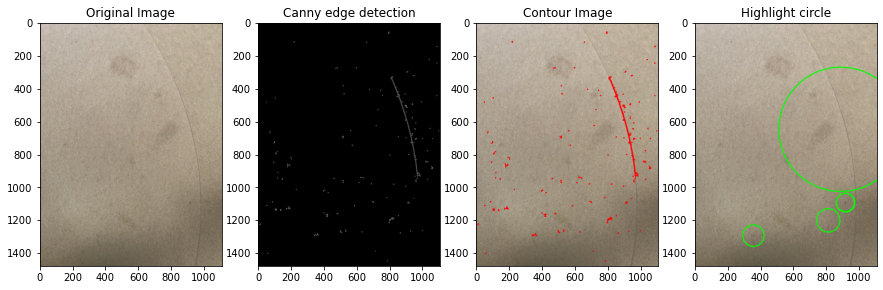

In [3]:
# Loading image
#
# org_img = cv2.imread('blob_1.jpg')
org_img = cv2.imread('blob_2.jpg')
# org_img = cv2.imread('blackspot.jpg')
# org_img = cv2.imread('blackspot_4.jpg')

img = org_img.copy()
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Gaussian blur
#
kernel_size = 3
blur_gray = cv2.GaussianBlur(gray_img,(kernel_size, kernel_size),5)

# Modify Gamma correction
#
# modi_gamma_img = modify_gamma_corrt(blur_gray, 3, 1.5)
# calcGrayHist(modi_gamma_img, "modi_gamma")
# Image Thresholding
#

# res,thresh_img = cv2.threshold(modi_gamma_img,5,50,cv2.THRESH_BINARY)

# thresh_img = cv2.adaptiveThreshold(blur_gray ,255, 
#                             cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
#                             cv2.THRESH_BINARY, 
#                             blockSize = 41, 
#                             C = 30)

thresh_img = cv2.Canny(blur_gray, 20, 110)

# Find contours
#
contours, hierarchy = cv2.findContours(thresh_img,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)

# Draw the circle pointer
#
areaThroshould = 50
for c in contours:
    area = cv2.contourArea(c)
    if area > areaThroshould and area < 2500:
        (x,y),radius = cv2.minEnclosingCircle(c)
        center = (int(x),int(y))
        radius = int(radius) + 50
        img_circle = cv2.circle(img,center,radius,(0,255,0),5)
        
# Plot
#    
fig  = plt.figure(num=1, figsize=[15,6])
plt.subplot(141)
plt.imshow(cv2.cvtColor(org_img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')

plt.subplot(142)
plt.imshow(thresh_img, cmap='gray')
plt.title('Canny edge detection')


plt.subplot(143)
plt.imshow(cv2.drawContours(cv2.cvtColor(org_img, cv2.COLOR_BGR2RGB), contours,-1,(255,0,0),3))
plt.title('Contour Image') 

plt.subplot(144)
plt.imshow(cv2.cvtColor(img_circle, cv2.COLOR_BGR2RGB))
plt.title('Highlight circle') 

now = time.strftime("%Y%m%d%H%M%S")
fig.savefig('defectDetection_{}.jpg'.format(now), dpi= 400)


D:\PythonProgm\lib\site-packages\ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


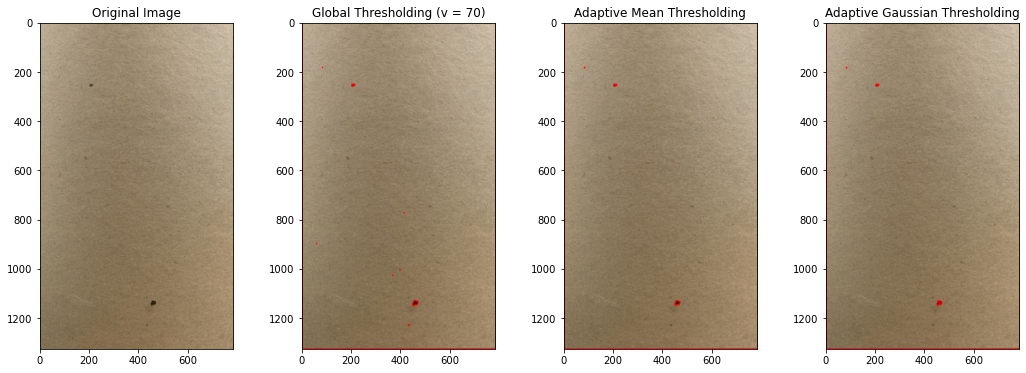

In [4]:
# black spot
img = cv2.imread('blackspot.jpg')
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# cv2.threshold(image, thresh, max, method) 
v = 70
ret,th1 = cv2.threshold(gray_img ,v ,255,cv2.THRESH_BINARY)
c1, h1 = cv2.findContours(th1,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE) 

# cv2.adaptiveThreshold(src, maxval, thresh_type, type, Block Size, C)
th2 = cv2.adaptiveThreshold(gray_img ,255, 
                            cv2.ADAPTIVE_THRESH_MEAN_C, 
                            cv2.THRESH_BINARY, 
                            blockSize = 151, 
                            C = 70)
c2, h2 = cv2.findContours(th2,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)  

th3 = cv2.adaptiveThreshold(gray_img ,255, 
                            cv2.cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                            cv2.cv2.THRESH_BINARY, 
                            blockSize = 151, 
                            C = 70)
c3, h3 = cv2.findContours(th3,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)  


titles = ['Original Image', 'Global Thresholding (v = {})'.format(v),
          'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
images =   [img, th1, th2, th3]
contours = [list(), c1, c2, c3]

fig = plt.figure(num=1, figsize=[18,6])

plt.title(titles[0])    
plt.subplot(1,4,1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))


for ii in range(4):   
    plt.subplot(1,4,ii + 1)
    plt.title(titles[ii]) 
    plt.imshow(cv2.drawContours(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), contours[ii],-1,(255,0,0),3))

now = time.strftime("%Y%m%d%H%M%S")
fig.savefig('defectDetection_{}.jpg'.format(now), dpi= 400)